# Tomato Disease Detection
Disease detection using transfer learning, and dataset balancing

In [4]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/emmarex/plantdisease")

Skipping, found downloaded files in "./plantdisease" (use force=True to force download)


### Removing Unecessary Data
Only take 🍅 data

In [6]:
import shutil

# Only take Tomato Dataset
try:
  shutil.rmtree('/content/plantdisease/plantvillage/')
  shutil.rmtree('/content/plantdisease/PlantVillage/Pepper__bell___Bacterial_spot')
  shutil.rmtree('/content/plantdisease/PlantVillage/Pepper__bell___healthy')
  shutil.rmtree('/content/plantdisease/PlantVillage/Potato___Early_blight')
  shutil.rmtree('/content/plantdisease/PlantVillage/Potato___Late_blight')
  shutil.rmtree('/content/plantdisease/PlantVillage/Potato___healthy')

except:
  print('Cannot find directory')

Cannot find directory


### Delete Augmented Data that used for Balancing

In [7]:
import shutil

try:
  shutil.rmtree('/content/aug')
except:
  print('Cannot find directory')

### Preview Image

In [8]:
import os

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import numpy as np
import pandas as pd

(256, 256, 3)


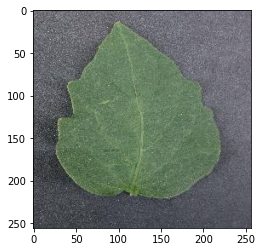

In [9]:
fpath = r'/content/plantdisease/PlantVillage/Tomato_healthy/000146ff-92a4-4db6-90ad-8fce2ae4fddd___GH_HL Leaf 259.1.JPG'
img = plt.imread(fpath)

print(img.shape)
imshow(img)

## Creating Pandas for Classes

In [10]:
source_dir = r'./plantdisease/PlantVillage'
subdir = os.listdir(source_dir)    

filepaths = []
labels = []    

for i in subdir:
  classpath = os.path.join(source_dir, i)
    
  if os.path.isdir(classpath):
    file_list = os.listdir(classpath)        
    for f in file_list:
      file_path = os.path.join(classpath, f)        
      filepaths.append(file_path)
      labels.append(i)

paths = pd.Series(filepaths, name='paths')
labels = pd.Series(labels, name='labels')    

df = pd.concat([paths, labels], axis=1)    

print(df.head())
print("========================")
print(df['labels'].value_counts())
print("========================")
print('Total data: ', len(df))

                                               paths               labels
0  ./plantdisease/PlantVillage/Tomato_Early_bligh...  Tomato_Early_blight
1  ./plantdisease/PlantVillage/Tomato_Early_bligh...  Tomato_Early_blight
2  ./plantdisease/PlantVillage/Tomato_Early_bligh...  Tomato_Early_blight
3  ./plantdisease/PlantVillage/Tomato_Early_bligh...  Tomato_Early_blight
4  ./plantdisease/PlantVillage/Tomato_Early_bligh...  Tomato_Early_blight
Tomato__Tomato_YellowLeaf__Curl_Virus          3209
Tomato_Bacterial_spot                          2127
Tomato_Late_blight                             1909
Tomato_Septoria_leaf_spot                      1771
Tomato_Spider_mites_Two_spotted_spider_mite    1676
Tomato_healthy                                 1591
Tomato__Target_Spot                            1404
Tomato_Early_blight                            1000
Tomato_Leaf_Mold                                952
Tomato__Tomato_mosaic_virus                     373
Name: labels, dtype: int64
Total dat

## Balancing Dataset
We will be cutting dataset into 700 image per class

In [11]:
sample_list = []
max_size = 700 # TODO: Change this value

grouping = df.groupby('labels')

for label in df['labels'].unique():                 
  group = grouping.get_group(label)
  group_size = len(group)    

  if group_size > max_size:
      samples = group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
  else:
      samples = group.sample(frac=1.0, replace=False, random_state=123, axis=0).reset_index(drop=True)
  sample_list.append(samples)

df = pd.concat(sample_list, axis=0).reset_index(drop=True)
print(df['labels'].value_counts())
print('Total data: ', len(df))     

Tomato_Early_blight                            700
Tomato_Septoria_leaf_spot                      700
Tomato_Leaf_Mold                               700
Tomato_Bacterial_spot                          700
Tomato_Late_blight                             700
Tomato__Target_Spot                            700
Tomato_healthy                                 700
Tomato_Spider_mites_Two_spotted_spider_mite    700
Tomato__Tomato_YellowLeaf__Curl_Virus          700
Tomato__Tomato_mosaic_virus                    373
Name: labels, dtype: int64
Total data:  6673


### Creating Augmented Dataset

We will be using augmented dataset to balanced the data

In [12]:
import os
import shutil
from keras.preprocessing.image import ImageDataGenerator

In [13]:
working_dir = r'./'
aug_dir = os.path.join(working_dir, 'aug')
if os.path.isdir(aug_dir):
    shutil.rmtree(aug_dir)
os.mkdir(aug_dir)
for label in df['labels'].unique():
    dir_path=os.path.join(aug_dir,label)    
    os.mkdir(dir_path)
print(os.listdir(aug_dir))

['Tomato_Early_blight', 'Tomato__Tomato_mosaic_virus', 'Tomato_Septoria_leaf_spot', 'Tomato_Leaf_Mold', 'Tomato_Bacterial_spot', 'Tomato_Late_blight', 'Tomato__Target_Spot', 'Tomato_healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Tomato_YellowLeaf__Curl_Virus']


In [14]:
target = 700 # set the target count for each class in df
gen = ImageDataGenerator(
  rotation_range=90, 
  brightness_range=[0.4, 1],
  horizontal_flip=True, 
  vertical_flip=True,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range=0.4,
  zoom_range = 0.15,
)

grouping = df.groupby('labels') # group by class

for label in df['labels'].unique():  # for every class               
  group = grouping.get_group(label)  # a dataframe holding only rows with the specified label 
  sample_count = len(group)   # determine how many samples there are in this class  
  if sample_count < target: # if the class has less than target number of images
      aug_img_count = 0

      delta = target - sample_count  # number of augmented images to create
      target_dir = os.path.join(aug_dir, label)  # define where to write the images    
      
      aug_gen = gen.flow_from_dataframe(
        group, 
        x_col='paths', 
        y_col=None, 
        target_size=(224,224), # change this target size based on transfer learning model
        class_mode=None,
        batch_size=1, 
        shuffle=False, 
        save_to_dir=target_dir, 
        save_prefix='aug-',
        save_format='jpg'
      )
      
      while aug_img_count < delta:
          images = next(aug_gen)            
          aug_img_count += len(images) 

Found 373 validated image filenames.


In [15]:
aug = r'./aug'
auglist = os.listdir(aug)
for class_name in auglist:
    classpath = os.path.join(aug, class_name)
    file_list = os.listdir(classpath)
    print('class:', class_name, 'file count:', len(file_list))

class: Tomato_Early_blight file count: 0
class: Tomato__Tomato_mosaic_virus file count: 327
class: Tomato_Septoria_leaf_spot file count: 0
class: Tomato_Leaf_Mold file count: 0
class: Tomato_Bacterial_spot file count: 0
class: Tomato_Late_blight file count: 0
class: Tomato__Target_Spot file count: 0
class: Tomato_healthy file count: 0
class: Tomato_Spider_mites_Two_spotted_spider_mite file count: 0
class: Tomato__Tomato_YellowLeaf__Curl_Virus file count: 0


### Preview Augmented Data

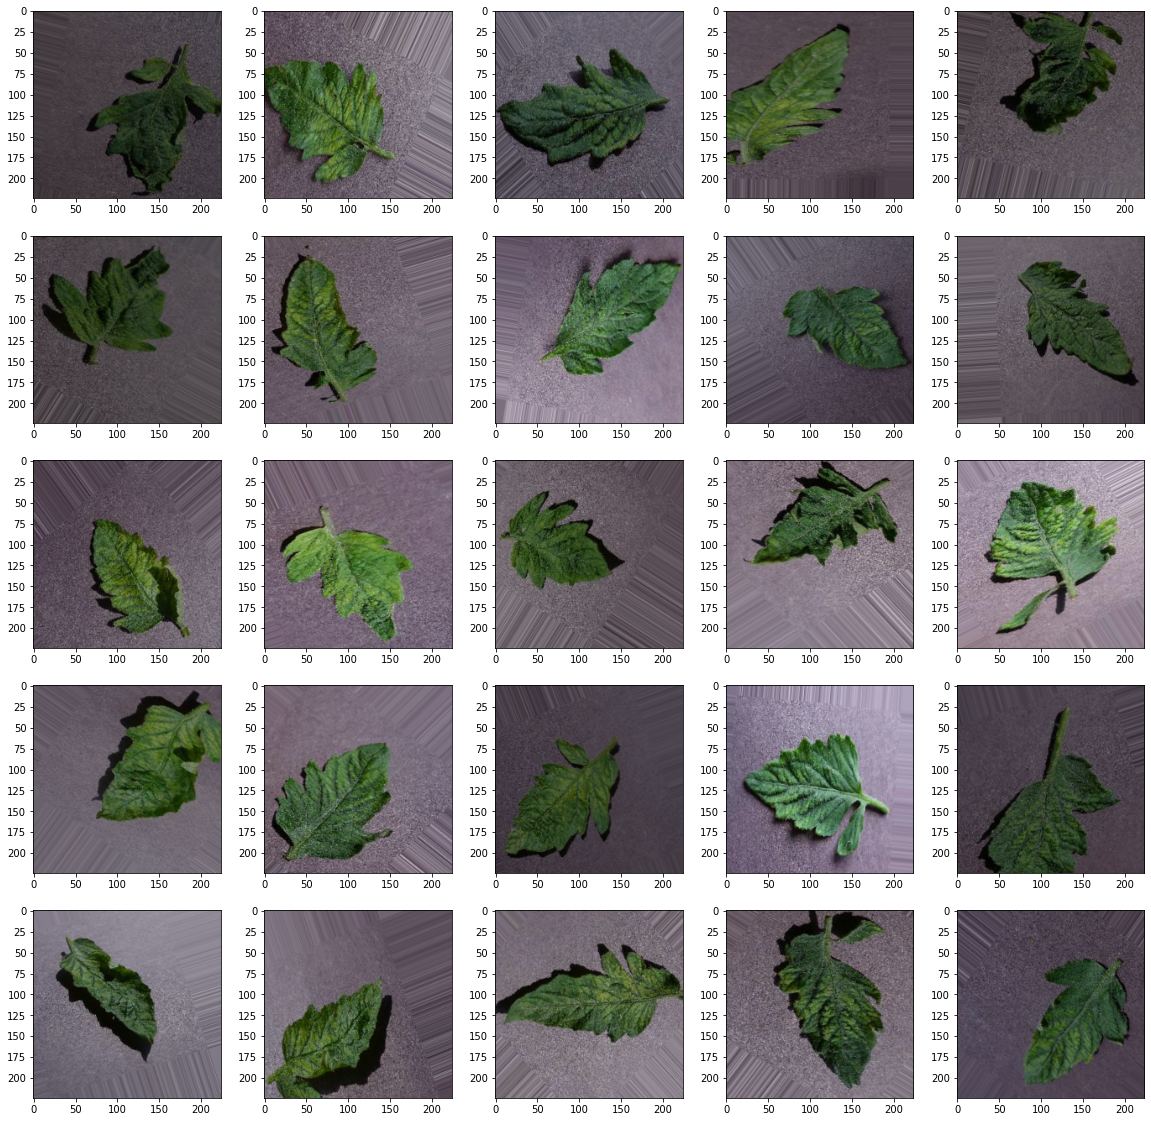

In [16]:
plt.figure(figsize=(20, 20))
for i in range(25):
    image = next(aug_gen) / 255
    image = np.squeeze(image, axis=0)
    plt.subplot(5, 5, i+1)
    plt.imshow(image)
    
plt.show()

In [17]:
aug_fpaths = []
aug_labels = []

classlist = os.listdir(aug_dir)

for class_names in classlist:
  classpath = os.path.join(aug_dir, class_names)     
  flist = os.listdir(classpath)    
  for f in flist:        
      fpath=os.path.join(classpath,f)         
      aug_fpaths.append(fpath)
      aug_labels.append(class_names)

Fseries = pd.Series(aug_fpaths, name='paths')
Lseries = pd.Series(aug_labels, name='labels')

aug_df = pd.concat([Fseries, Lseries], axis=1)

ndf = pd.concat([df,aug_df], axis=0).reset_index(drop=True)

print(df['labels'].value_counts()) 
print("=============================")
print(aug_df['labels'].value_counts())
print("=============================")
print(ndf['labels'].value_counts()) 

Tomato_Early_blight                            700
Tomato_Septoria_leaf_spot                      700
Tomato_Leaf_Mold                               700
Tomato_Bacterial_spot                          700
Tomato_Late_blight                             700
Tomato__Target_Spot                            700
Tomato_healthy                                 700
Tomato_Spider_mites_Two_spotted_spider_mite    700
Tomato__Tomato_YellowLeaf__Curl_Virus          700
Tomato__Tomato_mosaic_virus                    373
Name: labels, dtype: int64
Tomato__Tomato_mosaic_virus    352
Name: labels, dtype: int64
Tomato__Tomato_mosaic_virus                    725
Tomato_Early_blight                            700
Tomato_Septoria_leaf_spot                      700
Tomato_Leaf_Mold                               700
Tomato_Bacterial_spot                          700
Tomato_Late_blight                             700
Tomato__Target_Spot                            700
Tomato_healthy                              

# Model Training
**Model Parameters:**

Image Size: `256x256`

Image Type: `Color`

Batch Size: `16`

Validation Split: `80/20` (`80/(10/10))`, `70/30`, `50-50` (use preferably)

Transfer Learning Model: `EfficientNet`

For more model reference, check [this](https://keras.io/api/applications/)

In [18]:
# !pip install livelossplot

In [19]:
import os
from keras.models import Model
from keras.applications.efficientnet import EfficientNetB0, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from pathlib import Path
import numpy as np

import tensorflow as tf

# from livelossplot import PlotLossesKeras

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## Presets
Preset for model

In [20]:
EPOCHS = 50
BATCH_SIZE = 32

# Patience for reducing learning rate
PATIENCE = EPOCHS//5
LR_FACTOR = 0.2
WEIGHTS_FILE = "weights.h5" #File that stores updated weights

# IMG size for preprocessing
# Refer https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
IMG_SIZE = 224 

In [21]:
CLASS_NAMES = [
  "Tomato Bacterial Spot", 
  "Tomato Early Blight", 
  "Tomato Late Blight", 
  "Tomato Leaf Mold", 
  "Tomato Septoria Leaf Spot",
  "Tomato Spider Mites",
  "Tomato Target Spot",
  "Tomato Yellow Leaf Curl Virus",
  "Toamto Mosaic Virus",
  "Tomato Healthy" 
]

## Splitting Dataset 
**optional*\
Splitting dataset into train and validation and test set using sklearn

In [22]:
train_split = 0.8
valid_split = 0.1
dummy_split = valid_split / (1 - train_split)

train_df, dummy_df = train_test_split(ndf, train_size=train_split, shuffle=True, random_state=123)
valid_df, test_df = train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)

print ('train_df length:', len(train_df),'| test_df length:', len(test_df), '| valid_df length:', len(valid_df))

train_df length: 5620 | test_df length: 703 | valid_df length: 702


## Preprocessing + Augmentation + Splitting

In [23]:
def createTrainAndValidation():
  # PREPROCESSING LIST:

  # Rescaling
  # Random rotation up to 90 degree
  # Random brightness for bright environment
  # Flip image horizontally and vertically
  # Random image shearing
  # Width and Height shifting
  # Zoom

  datagen = ImageDataGenerator(
    rotation_range=90, 
    brightness_range=[0.4, 1],
    horizontal_flip=True, 
    vertical_flip=True,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range=0.4,
    zoom_range = 0.15,
    fill_mode="nearest",
    preprocessing_function=preprocess_input
  )
  # datagen = ImageDataGenerator(
  #   preprocessing_function=preprocess_input
  # )

  test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_data = datagen.flow_from_dataframe( 
    train_df, 
    x_col='paths', 
    y_col='labels', 
    target_size=(IMG_SIZE, IMG_SIZE), 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=True, 
    batch_size=BATCH_SIZE
  )
  valid_data = datagen.flow_from_dataframe(
    valid_df, 
    x_col='paths', 
    y_col='labels', 
    target_size=(IMG_SIZE, IMG_SIZE), 
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True, 
    batch_size=BATCH_SIZE
  )

  # test_data = test_generator.flow_from_dataframe(
  #     test_df, 
  #     x_col='paths', 
  #     y_col='labels', 
  #     target_size=(IMG_SIZE, IMG_SIZE), 
  #     class_mode='categorical',
  #     color_mode='rgb', 
  #     shuffle=False, 
  #     batch_size=test_batch_size
  # )

  return [train_data, valid_data]

## Callback Functions for Model

In [24]:
def assign_callbacks(weights_file,patience,lr_factor):
  return[
    # Saving weights that can be used
    # Only save the weights that correspond to the minimum validation loss.
    ModelCheckpoint(
      filepath=weights_file,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True ,
      save_weights_only=True,
      verbose=0
    ),
    # If val_loss doesn't improve for a number of epochs set with 'patience' 
    # variable, training will stop to avoid overfitting.    
    EarlyStopping(
      monitor='val_loss',
      mode='min',
      patience=patience,
      verbose=1
    ),
    # Learning rate is reduced by 'lr_factor' if val_loss stagnates
    # for a number of epochs set with 'patience/2' variable.
    ReduceLROnPlateau(
      monitor='val_loss',
      mode='min',
      factor=lr_factor,
      patience=patience//2,
      min_lr=1e-6,
      verbose=1
    ),
    # Livelossplot to show live preview plotting
    # *optional
    # PlotLossesKeras()
  ]

## Create Model

In [25]:
# Create the whole neural network, pass the base model as parameter.
def create_model(base_model):
      x = base_model.output
      x = GlobalAveragePooling2D()(x)
      x = BatchNormalization()(x)

      # TODO: re-tune this parameter
      # x = Dense(32, activation='relu')(x)
      # x = Dense(64, activation='relu')(x)
      # x = Dropout(0.2)(x)
      x = Flatten()(x)

      predictions = Dense(10, activation='softmax')(x)
      model = Model(
        inputs=base_model.input, 
        outputs=predictions,
        name="Tomato_Disease"
      )

      # Freeze layers of the base model
      # prevents the weights in a given layer from being updated during training
      # for more info https://www.tensorflow.org/tutorials/images/transfer_learning#freeze_the_convolutional_base
      for layer in base_model.layers:
        layer.trainable = False

      # print("Numbers of layer in model:", len(base_model.layers))

      # base_model.trainable = True

      # fine_tune_at = 100
      # for layer in base_model.layers[:fine_tune_at]:
      #   layer.trainable = False

      # for layer in base_model.layers[-20:]:
      #   if not isinstance(layer, BatchNormalization):
      #       layer.trainable = True

      # Add learning rate (default: 1e-3)
      # TODO: decrease this if loss does not decrease
      # decrease up to : 1e-4 / 1e-5 / 3e-5
      base_learning_rate = 0.001
      model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
        loss='categorical_crossentropy',
        metrics='accuracy'
      )
      
      return model

In [26]:
train_data, valid_data = createTrainAndValidation()

# Define callbacks for training
callbacks = assign_callbacks(WEIGHTS_FILE,PATIENCE,LR_FACTOR)

Found 5620 validated image filenames belonging to 10 classes.
Found 702 validated image filenames belonging to 10 classes.


In [27]:
# Create the base pre-trained model
base_model = EfficientNetB0(
  weights='imagenet',
  include_top=False,
  input_shape=(IMG_SIZE,IMG_SIZE,3)
)
#Create the complete new model.
model = create_model(base_model)

In [28]:
# Information about the model's layers.
# model.summary()

## Training Model

In [29]:
# Train the model on the dataset.
history=model.fit(
  x=train_data, 
  batch_size=BATCH_SIZE,
  epochs=EPOCHS, 
  verbose=1,
  validation_data=valid_data,
  callbacks=callbacks
) 

Epoch 1/50
176/176 [==============================] - 398s 2s/step - loss: 1.0947 - accuracy: 0.6278 - val_loss: 0.8916 - val_accuracy: 0.7863 - lr: 0.0010
Epoch 2/50
176/176 [==============================] - 378s 2s/step - loss: 0.5975 - accuracy: 0.8005 - val_loss: 0.5277 - val_accuracy: 0.8405 - lr: 0.0010
Epoch 3/50
176/176 [==============================] - 381s 2s/step - loss: 0.5186 - accuracy: 0.8217 - val_loss: 0.4252 - val_accuracy: 0.8675 - lr: 0.0010
Epoch 4/50
176/176 [==============================] - 420s 2s/step - loss: 0.4441 - accuracy: 0.8473 - val_loss: 0.4053 - val_accuracy: 0.8704 - lr: 0.0010
Epoch 5/50
176/176 [==============================] - 381s 2s/step - loss: 0.4072 - accuracy: 0.8628 - val_loss: 0.3540 - val_accuracy: 0.8903 - lr: 0.0010
Epoch 6/50
176/176 [==============================] - 421s 2s/step - loss: 0.3863 - accuracy: 0.8722 - val_loss: 0.3487 - val_accuracy: 0.8932 - lr: 0.0010
Epoch 7/50
176/176 [==============================] - 379s 2s/st

## Plotting Model

In [30]:
# Plot training learning curves for both train and validation.
def plot_training_curves(history):
        # Defining the metrics we will plot.
        train_acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        
        # Range for the X axis.
        epochs = range(len(train_loss))
        
        fig,axis = plt.subplots(1,2,figsize=(20,8)) # 1 row, 2 col, width = 20, height = 8 inches.

        # Plotting Loss figures.
        plt.rcParams.update({'font.size': 22}) #configuring font size.
        plt.subplot(1, 2, 1) #plot 1st curve.
        plt.plot(epochs, train_loss, c="red", label="Training Loss") #plotting
        plt.plot(epochs, val_loss, c="blue", label="Validation Loss")
        plt.xlabel("Epochs") #title for x axis
        plt.ylabel("Loss")   #title for y axis
        plt.legend()

        # Plotting Accuracy figures. 
        plt.subplot(1, 2, 2) # plot 2nd curve.
        plt.plot(epochs, train_acc, c="red", label="Training Acc") # plotting
        plt.plot(epochs, val_acc, c="blue", label="Validation Acc")
        plt.xlabel("Epochs")   # title for x axis
        plt.ylabel("Accuracy") # title for y axis
        plt.legend()

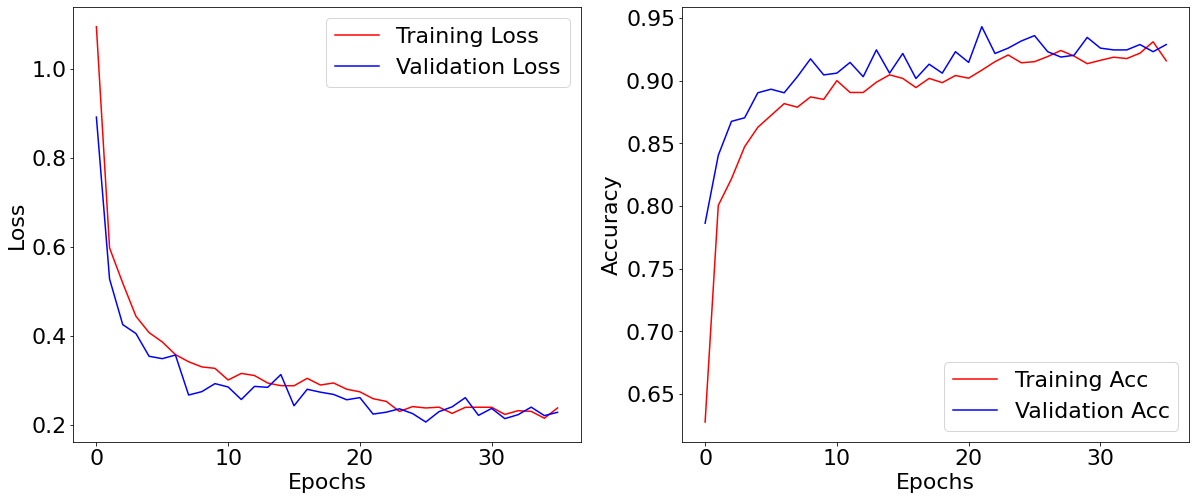

In [31]:
plot_training_curves(history)

## Saving Model to TFLite + Quantize Model

In [32]:
# Load optimal weights computed during training.
model.load_weights(WEIGHTS_FILE)
# Convert the model to it's Tensorflow Lite equivalent
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT] # Quantized
tflite_model = converter.convert()

# Save the model.
with open('model.tfliteQuant', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpa_iqh1_8/assets
